# Data Exploration

Download this dataset:
https://www.kaggle.com/btolar1/weka-german-credit

The dataset contains 1000 entries with 20 categorial/symbolic attributes. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad (CLASS attribute) credit risks according to the set of attributes.

Project includes: 

- Data preparation and Data exploration
- Identify data features which drive the credit risk
- Modeling the credit risk
- Model validation and evaluation


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 3)
plt.rcParams['font.family'] = 'sans-serif'

pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

## read in data

In [2]:
data = pd.read_csv('../data/raw/credit-g.csv')

Examine data types for each column

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_status           1000 non-null object
duration                  1000 non-null int64
credit_history            1000 non-null object
purpose                   1000 non-null object
credit_amount             1000 non-null int64
savings_status            1000 non-null object
employment                1000 non-null object
installment_commitment    1000 non-null int64
personal_status           1000 non-null object
other_parties             1000 non-null object
residence_since           1000 non-null int64
property_magnitude        1000 non-null object
age                       1000 non-null int64
 other_payment_plans      1000 non-null object
housing                   1000 non-null object
existing_credits          1000 non-null int64
job                       1000 non-null object
num_dependents            1000 non-null int64
own_telephone             1000 non-null object
 foreign

### Remove whitespace from column headers

In [5]:
data.rename(columns=lambda x: x.strip(), inplace=True)

Check whitespace removed

### Goal is to predict `class` – whether someone does or does not complete loan repayment. This is a little unbalanced, with 700 people repaying (`good`) and 300 not (`bad`)

In [7]:
data['class'].unique()

array(['good', 'bad'], dtype=object)

In [8]:
data['class'].value_counts()

good    700
bad     300
Name: class, dtype: int64

### All data looks present, with no missing values in any column.

In [9]:
data.isnull().sum()

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64

# Data exploration

### Transform the predicted class `class` into a label:

In [10]:
class_lb = LabelBinarizer()
data['y'] = class_lb.fit_transform(data['class'].values)

In [11]:
data.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,y
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes,good,1
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes,bad,0
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes,good,1
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes,good,1
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes,bad,0


### Explore continuous valiables: relationships with the dependent variable `y`, with each other, and their distributions.

In [12]:
numeric_cols = ['y', 'duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']

* **`residence_since`, `age`, `existing_credits` and `num_dependents` have the same – or very similar – means and medians between groups who default on the loan vs those who do not. Therefore, these features are unlikely to be useful.**
* **`Age` is also a protected characteristic, meaning we cannot use it to determine whether or not someone can get a loan. `Age` must be removed.**

In [13]:
data[numeric_cols].groupby('y').mean()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
y,,,,,,,
0,24.860000,3938.126667,3.096667,2.850000,33.963333,1.366667,1.153333
1,19.207143,2985.457143,2.920000,2.842857,36.224286,1.424286,1.155714


In [14]:
data[numeric_cols].groupby('y').median()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
y,,,,,,,
0,24.0,2574.5,4.0,3.0,31.0,1.0,1.0
1,18.0,2244.0,3.0,3.0,34.0,1.0,1.0


In [15]:
data.drop(columns=['residence_since', 'existing_credits', 'num_dependents', 'age'], inplace=True)

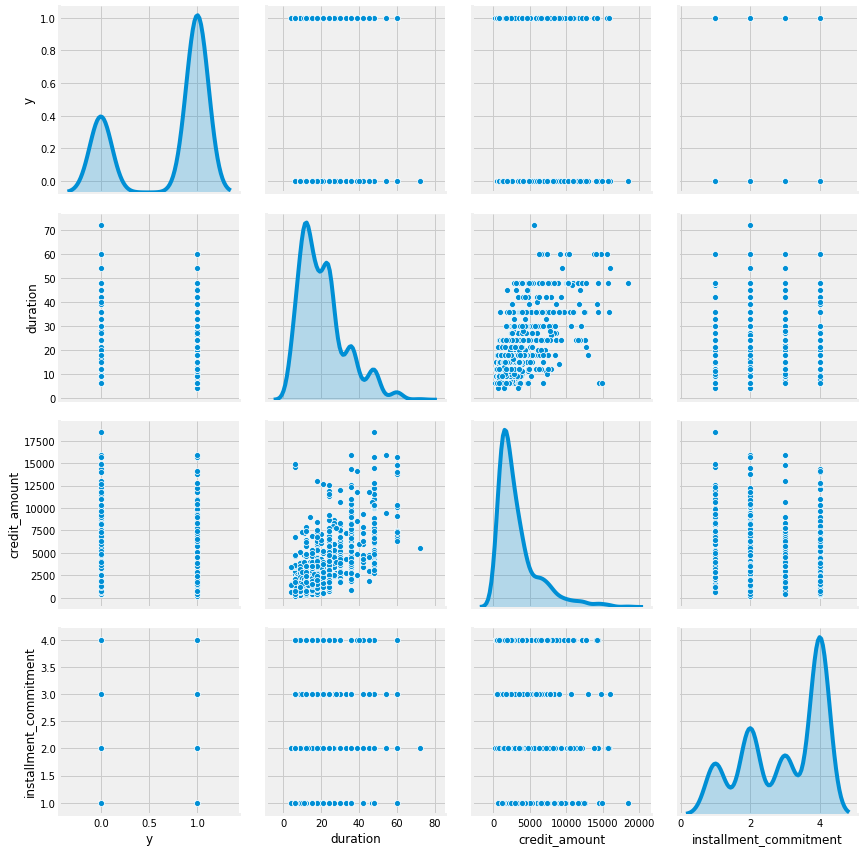

In [16]:
sns.pairplot(data[['y', 'duration', 'credit_amount', 'installment_commitment']], diag_kind='kde', height=3)

• **Of the continuous variables (non-categorical), `credit_amount` correlates somewhat with `duration` (0.62). These two features are also not independent from one another, as you would expect larger loans to be paid back over a longer period of time. Therefore, we will take the stronger feature forward.**


• **`duration` has the strongest relationship with the dependent variable `y` with `-21` meaning that the longer the duration, the less likely people are to complete payments.**

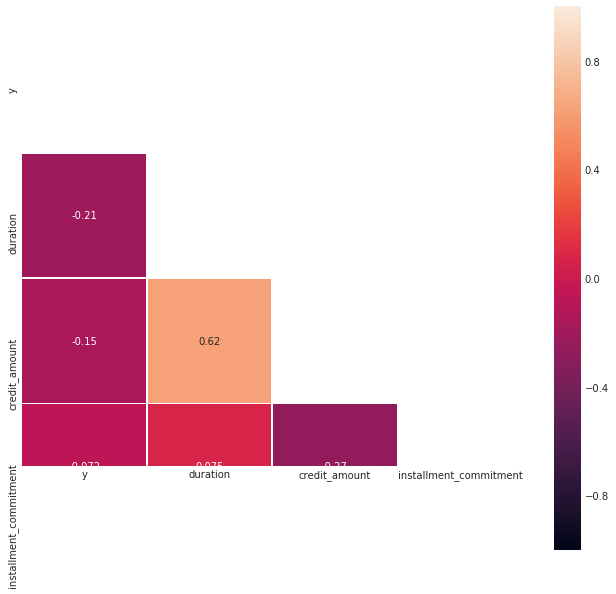

In [17]:
mask = np.zeros_like(data[['y', 'duration', 'credit_amount', 'installment_commitment']].corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 10))
with sns.axes_style("white"):
    ax = sns.heatmap(data[['y', 'duration', 'credit_amount', 'installment_commitment']].corr(), mask=mask, 
                     linewidths=0.5, annot=True, robust=True, square=True,  vmin=-1, vmax=1)

In [18]:
data.drop(columns=['credit_amount', 'installment_commitment'], inplace=True)

In [19]:
data.head()

,checking_status,duration,credit_history,purpose,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker,class,y
0,<0,6,critical/other existing credit,radio/tv,no known savings,>=7,male single,none,real estate,none,own,skilled,yes,yes,good,1
1,0<=X<200,48,existing paid,radio/tv,<100,1<=X<4,female div/dep/mar,none,real estate,none,own,skilled,none,yes,bad,0
2,no checking,12,critical/other existing credit,education,<100,4<=X<7,male single,none,real estate,none,own,unskilled resident,none,yes,good,1
3,<0,42,existing paid,furniture/equipment,<100,4<=X<7,male single,guarantor,life insurance,none,for free,skilled,none,yes,good,1
4,<0,24,delayed previously,new car,<100,1<=X<4,male single,none,no known property,none,for free,skilled,none,yes,bad,0


# Explore the Categorical variables:

## We have columns of different data types:

• **Categorical ordinal**:

    - 'employment' 
    
• **Categorical nominal**:

    - 'checking_status', 'savings_status', 'credit_history', 'purpose', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker' 

In [20]:
ordinal = ['checking_status', 'savings_status', 'employment']
nominal = ['credit_history', 'purpose', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 
           'housing', 'job', 'own_telephone', 'foreign_worker']

## Ordinal Categories:

**`employment`**:

People who are employed for different durations of time seem to be as likely to pay or not pay. Therefore, this feature may not be useful:

In [21]:
data.groupby('employment').y.mean()

employment
1<=X<4        0.693215
4<=X<7        0.775862
<1            0.593023
>=7           0.747036
unemployed    0.629032
Name: y, dtype: float64

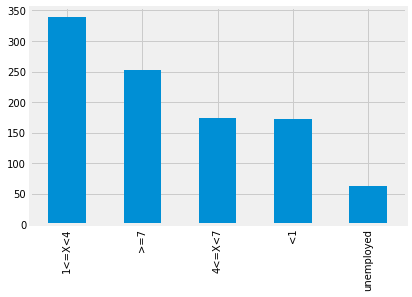

In [22]:
data.employment.value_counts().plot.bar()

## Nominal Categories:

**`checking_status`** 

Most of the classes in this feature can be ordered. However, it is not clear in an ordered list where `no_checking` should go. Therefore, this feature will be treated as a nominal category rather than ordinal.

The vast majority of people without a bank account / no known bank account do pay back the loan, along with those with more than €200 in their account, compared with people with less than €200, and less than €0 (overdrawn?). This appears to be a useful feature:

In [23]:
data.groupby('checking_status').y.mean()

checking_status
0<=X<200       0.609665
<0             0.507299
>=200          0.777778
no checking    0.883249
Name: y, dtype: float64

In [24]:
data[data.y == 1].checking_status.value_counts()

no checking    348
0<=X<200       164
<0             139
>=200           49
Name: checking_status, dtype: int64

In [25]:
data[data.y == 0].checking_status.value_counts()

<0             135
0<=X<200       105
no checking     46
>=200           14
Name: checking_status, dtype: int64

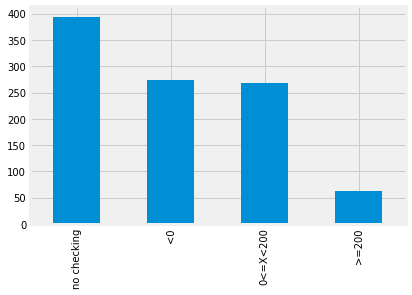

In [26]:
data.checking_status.value_counts().plot.bar()

**`savings_status`**

Savings status will also be considered a nominal catagorical feature given that there is an unknown class in the category, and something `uknown` cannot be easily ordered. People with more than €500 or no known savings are more likely to pay, compared with those with less than €500:

In [28]:
data.groupby('savings_status').y.mean()

savings_status
100<=X<500          0.669903
500<=X<1000         0.825397
<100                0.640133
>=1000              0.875000
no known savings    0.825137
Name: y, dtype: float64

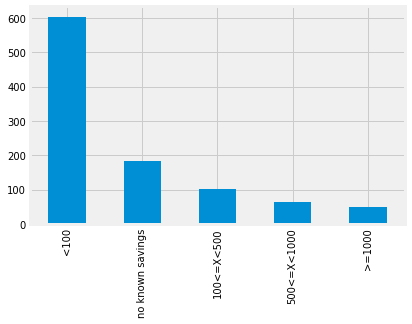

In [29]:
data.savings_status.value_counts().plot.bar()

**`credit_history`**

This looks like a useful feature

In [30]:
data.groupby('credit_history').y.mean()

credit_history
all paid                          0.428571
critical/other existing credit    0.829352
delayed previously                0.681818
existing paid                     0.681132
no credits/all paid               0.375000
Name: y, dtype: float64

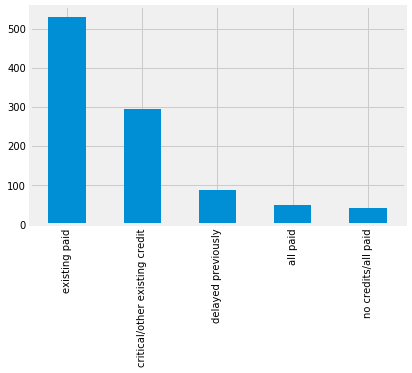

In [31]:
data.credit_history.value_counts().plot.bar()

**`purpose`**
This may be a useful feature

In [32]:
data.groupby('purpose').y.mean()

purpose
business               0.649485
domestic appliance     0.666667
education              0.560000
furniture/equipment    0.679558
new car                0.619658
other                  0.583333
radio/tv               0.778571
repairs                0.636364
retraining             0.888889
used car               0.834951
Name: y, dtype: float64

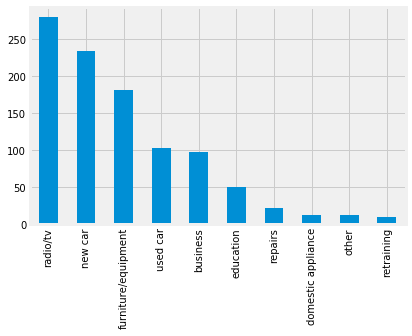

In [33]:
data.purpose.value_counts().plot.bar()

**`personal_status`**

Marital status, sex and sexual orientation are all protected characteristics that make it unlawful to discriminate using these characteristics. Therefore, we cannot use this feature to determine whether someone will or will not pay a loan. 

In [34]:
data.groupby('personal_status').y.mean()

personal_status
female div/dep/mar    0.648387
male div/sep          0.600000
male mar/wid          0.728261
male single           0.733577
Name: y, dtype: float64

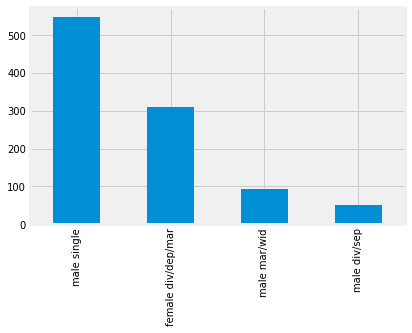

In [35]:
data.personal_status.value_counts().plot.bar()

In [36]:
data.drop(columns=['personal_status'], inplace=True)

**`other_parties`**

This may be a useful feature

In [37]:
data.groupby('other_parties').y.mean()

other_parties
co applicant    0.560976
guarantor       0.807692
none            0.700110
Name: y, dtype: float64

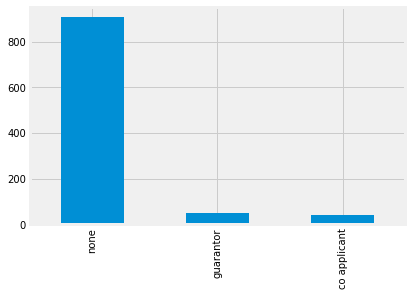

In [38]:
data.other_parties.value_counts().plot.bar()

**`property_magnitude`**

This may possibly be a useful feature

In [39]:
data.groupby('property_magnitude').y.mean()

property_magnitude
car                  0.692771
life insurance       0.693966
no known property    0.564935
real estate          0.787234
Name: y, dtype: float64

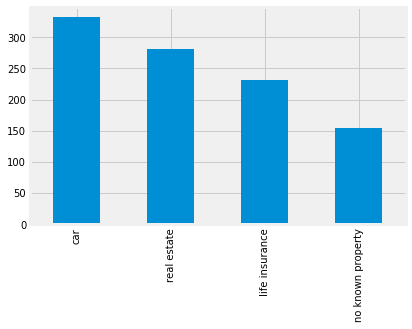

In [40]:
data.property_magnitude.value_counts().plot.bar()

**`other_payment_plans`**

This one is a close category with not much difference between the options, and therefore may not be a useful feature

In [41]:
data.groupby('other_payment_plans').y.mean()

other_payment_plans
bank      0.589928
none      0.724816
stores    0.595745
Name: y, dtype: float64

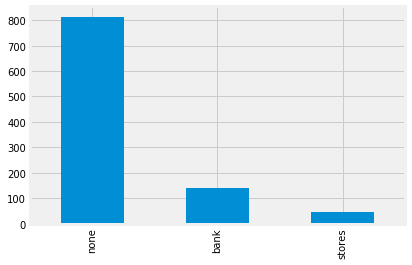

In [42]:
data.other_payment_plans.value_counts().plot.bar()

**`housing`**

Another close category and therefore may not be useful

In [43]:
data.groupby('housing').y.mean()

housing
for free    0.592593
own         0.739130
rent        0.608939
Name: y, dtype: float64

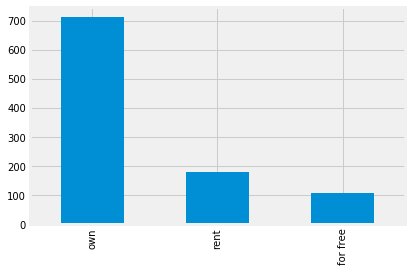

In [44]:
data.housing.value_counts().plot.bar()

**`job`**

A very close category and therefore will be removed.

In [45]:
data.groupby('job').y.mean()

job
high qualif/self emp/mgmt    0.655405
skilled                      0.704762
unemp/unskilled non res      0.681818
unskilled resident           0.720000
Name: y, dtype: float64

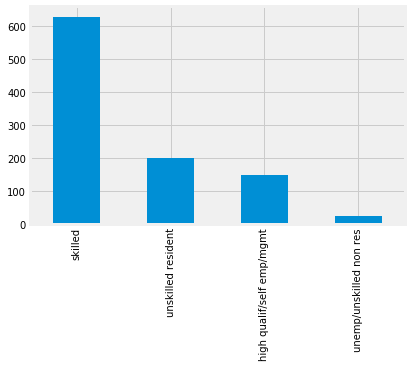

In [46]:
data.job.value_counts().plot.bar()

In [47]:
data.drop(columns='job', inplace=True)

**`own_telephone`**

This is a very close category, and will be removed.

In [48]:
data.groupby('own_telephone').y.mean()

own_telephone
none    0.686242
yes     0.720297
Name: y, dtype: float64

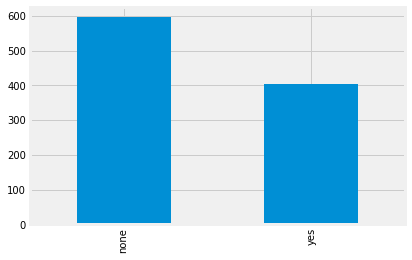

In [49]:
data.own_telephone.value_counts().plot.bar()

In [50]:
# recode to binary
data.drop(columns='own_telephone', inplace=True)

In [51]:
data.head()

,checking_status,duration,credit_history,purpose,savings_status,employment,other_parties,property_magnitude,other_payment_plans,housing,foreign_worker,class,y
0,<0,6,critical/other existing credit,radio/tv,no known savings,>=7,none,real estate,none,own,yes,good,1
1,0<=X<200,48,existing paid,radio/tv,<100,1<=X<4,none,real estate,none,own,yes,bad,0
2,no checking,12,critical/other existing credit,education,<100,4<=X<7,none,real estate,none,own,yes,good,1
3,<0,42,existing paid,furniture/equipment,<100,4<=X<7,guarantor,life insurance,none,for free,yes,good,1
4,<0,24,delayed previously,new car,<100,1<=X<4,none,no known property,none,for free,yes,bad,0


**`foreign_worker`**

Although this feature looks like it may be useful, it's possible that foreign worker status could be a proxy for race, which is a protected characteristic under human rights law. Therefore this feature will not be used in this analysis. 

In [52]:
data.groupby('foreign_worker').y.mean()

foreign_worker
no     0.891892
yes    0.692627
Name: y, dtype: float64

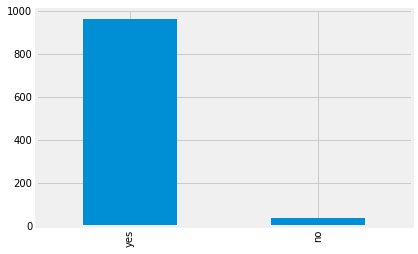

In [53]:
data.foreign_worker.value_counts().plot.bar()

In [54]:
data.drop(columns=['foreign_worker'], inplace=True)

In [55]:
data.head()

,checking_status,duration,credit_history,purpose,savings_status,employment,other_parties,property_magnitude,other_payment_plans,housing,class,y
0,<0,6,critical/other existing credit,radio/tv,no known savings,>=7,none,real estate,none,own,good,1
1,0<=X<200,48,existing paid,radio/tv,<100,1<=X<4,none,real estate,none,own,bad,0
2,no checking,12,critical/other existing credit,education,<100,4<=X<7,none,real estate,none,own,good,1
3,<0,42,existing paid,furniture/equipment,<100,4<=X<7,guarantor,life insurance,none,for free,good,1
4,<0,24,delayed previously,new car,<100,1<=X<4,none,no known property,none,for free,bad,0


In [54]:
data.to_csv('../data/interim/data_interim.csv', index=False)